In [29]:
%matplotlib notebook
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from itertools import cycle
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AffinityPropagation, OPTICS, cluster_optics_dbscan
from gensim.models.keyedvectors import KeyedVectors

sns.set_style('darkgrid')

# Read code vectors
DATASET_NAME = "python"
MODEL_NAME = "py_model"

# Load data

In [30]:
library_embeddings = f'./data/{DATASET_NAME}/libraries.txt'
target_embeddings = f'./data/{DATASET_NAME}/targets.txt'

# Load code vectors and labels
vectors = pd.read_csv(f'./data/{DATASET_NAME}/{DATASET_NAME}.test.c2v.vectors', sep=" ", header=None)
labels = pd.read_csv(f'./data/{DATASET_NAME}/{DATASET_NAME}.test.c2v', sep=" ").iloc[:, 0]

embedding_shape = vectors.values.shape[1]

# Merge vectors and labels, create numerical labels
df = vectors.assign(label=labels)
df.dropna(inplace=True)

# Count number of occurrences for each label
df['count'] = df.groupby('label')['label'].transform('count')
df.head()

/home/marcus/anaconda3/envs/scc/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,0,1,2,3,4,5,6,7,8,9,...,120,121,122,123,124,125,126,127,label,count
0,-0.770248,-0.202049,-0.500844,-0.309112,-0.069341,-0.613163,0.638034,0.174118,0.608707,0.218612,...,-0.862851,-0.787611,0.756607,-0.906835,0.787232,-0.952545,0.378361,0.793803,test|resample|stratify|sparse|error,1
1,-0.487017,-0.226648,-0.188069,0.659403,0.248502,-0.240976,0.391461,-0.962360,0.411059,0.788724,...,-0.323600,-0.146425,-0.851221,0.240862,-0.396322,-0.242584,-0.718291,0.425551,searchlast,1
2,-0.829948,0.988526,0.843886,0.817478,0.751317,-0.091607,0.959419,-0.885774,-0.938064,-0.906159,...,0.009332,-0.996812,0.734298,0.995477,-0.989847,-0.963852,0.483853,-0.525080,call,644
3,0.048491,-0.083818,0.972620,-0.349164,0.613048,-0.487225,0.905924,0.866015,-0.239299,-0.918267,...,0.978091,0.379985,0.572275,-0.193356,0.644361,-0.998775,-0.875450,0.856357,test|max|pooling3d|channels|first,2
4,-0.113630,0.422379,-0.928579,0.741841,-0.690615,0.348135,0.538308,0.805273,0.967783,0.626692,...,0.857253,0.918889,0.931588,-0.682605,-0.473296,0.610859,-0.650325,0.861767,test|conll|writer|whitespace|after,2


# Check for similarities and analogies in the dataset

In [31]:
# Similarities and Analogies
w2v = KeyedVectors.load_word2vec_format(library_embeddings, binary=False)
t2v = KeyedVectors.load_word2vec_format(target_embeddings, binary=False)

token_vocab = w2v.vocab.keys()
target_vocab = t2v.vocab.keys()
print(f"Loaded embeddings for {len(token_vocab)} tokens and {len(target_vocab)} targets.")


# prints libraries in your model having 'name' as a substring
def find_library(name, vocab):
    result = []
    for l in vocab:
        if name in l:
            result.append(l)
    return result

Loaded embeddings for 76728 tokens and 124902 targets.


In [32]:
print(t2v.most_similar('evaluate'))
# print(find_library('evaluate', target_vocab))

[('||init||', 0.4308181405067444), ('predict', 0.4214800000190735), ('main', 0.4063037633895874), ('||call||', 0.39186155796051025), ('train', 0.3836973309516907), ('set|up', 0.38054925203323364), ('update', 0.37433865666389465), ('fit', 0.3626998960971832), ('encode', 0.3447763919830322), ('test', 0.3359939157962799)]


In [33]:
print(find_library('torch.nn.Sequential', token_vocab))
print(find_library('tensorflow.keras.Sequential', token_vocab))
print(w2v.similarity('torch.nn.Sequential', 'tensorflow.keras.Sequential'))

['torch.nn.Sequential', 'torch.nn.Sequential.to', 'torch.nn.Sequential.shape', 'torch.nn.Sequential.apply', 'torch.nn.Sequential.eval']
['tensorflow.keras.Sequential', 'tensorflow.keras.Sequential.add', 'tensorflow.keras.Sequential.compile', 'tensorflow.keras.Sequential.fit', 'tensorflow.keras.Sequential.evaluate', 'tensorflow.keras.Sequential.predict']
0.3864548


In [34]:
print(w2v.most_similar('tensorflow.keras.Sequential'))

[('seq2seq_model', 0.5415372252464294), ('sagemaker.xgboost.model.XGBoostModel', 0.532568097114563), ('bert.modeling.get_pooled_output', 0.5185986757278442), ('sklearn.mixture.fit', 0.5109903216362), ('tensorflow.random_uniform_initializer', 0.4988861083984375), ('tensorflow.keras.initializers.TruncatedNormal', 0.497152715921402), ('model', 0.49269595742225647), ('sagemaker.local.entities._LocalModel', 0.490397572517395), ('sagemaker.deprecations.removed_kwargs', 0.4827228784561157), ('seq2seq_model.Seq2SeqModel', 0.4767313599586487)]


# Visualize the dataset with t-SNE & PCA

In [35]:

# Use to limit the number of samples (if necessary for computational reasons)
rndperm = np.random.permutation(df.shape[0])
N = 10000
df_small = df.loc[rndperm[:N],:].copy()

data = df_small.iloc[:, 0:embedding_shape-1].values

# t-SNE on many different labels
tsne2d = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=3000)
tsne_result_2d_all = tsne2d.fit_transform(data)

tsne3d = TSNE(n_components=3, verbose=1, perplexity=30, n_iter=3000)
tsne_result_3d_all = tsne3d.fit_transform(data)

# PCA on many different labels
pca = PCA(n_components=100)
pca_result_all = pca.fit_transform(data)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.079s...
[t-SNE] Computed neighbors for 10000 samples in 19.076s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 97.340408
[t-SNE] KL divergence after 3000 iterations: 2.036466
[t-SNE] Computing 91 nea

<IPython.core.display.Javascript object>


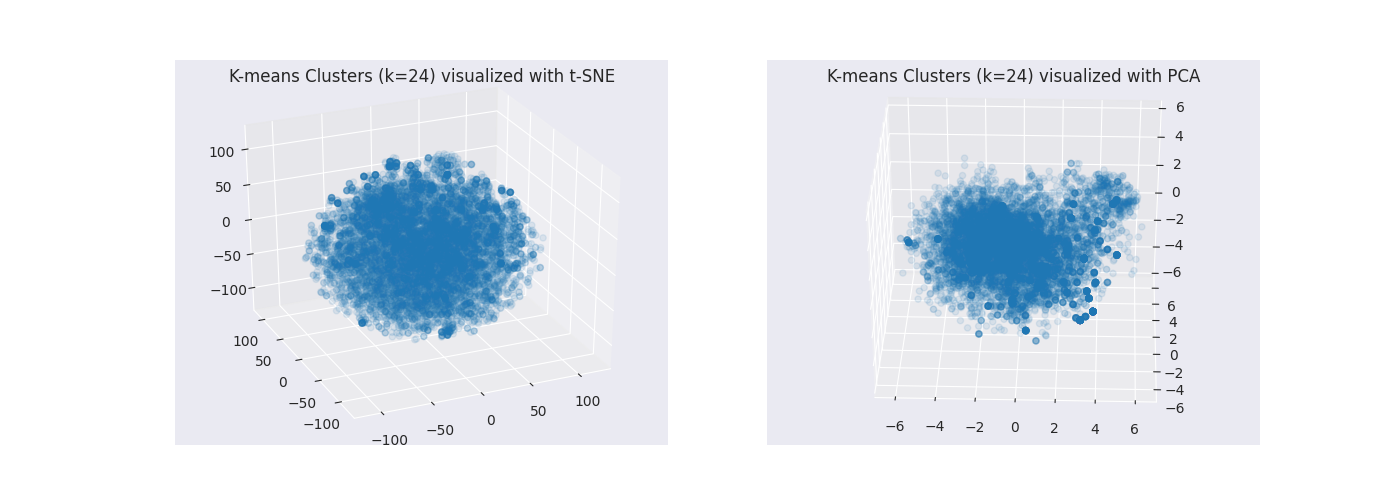

In [42]:
# Try to visualize clusters using t-SNE in 3D
fig = plt.figure(figsize=(14,5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.set_title('Dataset visualized with t-SNE')
ax1.scatter(tsne_result_3d_all[:, 0], tsne_result_3d_all[:, 1], tsne_result_3d_all[:, 2], alpha=0.1)

ax2 = fig.add_subplot(122, projection='3d')
ax2.set_title('Dataset visualized with PCA')
ax2.scatter(pca_result_all[:, 0], pca_result_all[:, 1], pca_result_all[:, 2], alpha=0.1)

# Attempt k-means clustering on the large dataset
Use the Elbow method (sum of square distances between clusters) and silhouette score to try to find a good value for k.

## Silhouette Score
Meaning of the value
 - 1: Clusters are well apart/distinguished.
 - 0: Clusters are indifferent / no meaningful distance between them.
 - -1: Clusters are assigned in the wrong way

In [36]:
# Search for a good k
sum_of_squared_distances = []
silhouette_scores = []
K = range(2,25)
for k in K:
    km = KMeans(n_clusters=k, random_state=0)
    km = km.fit(data)
    sum_of_squared_distances.append(km.inertia_)
    silhouette_scores.append(metrics.silhouette_score(data, km.labels_, metric='sqeuclidean'))

<IPython.core.display.Javascript object>


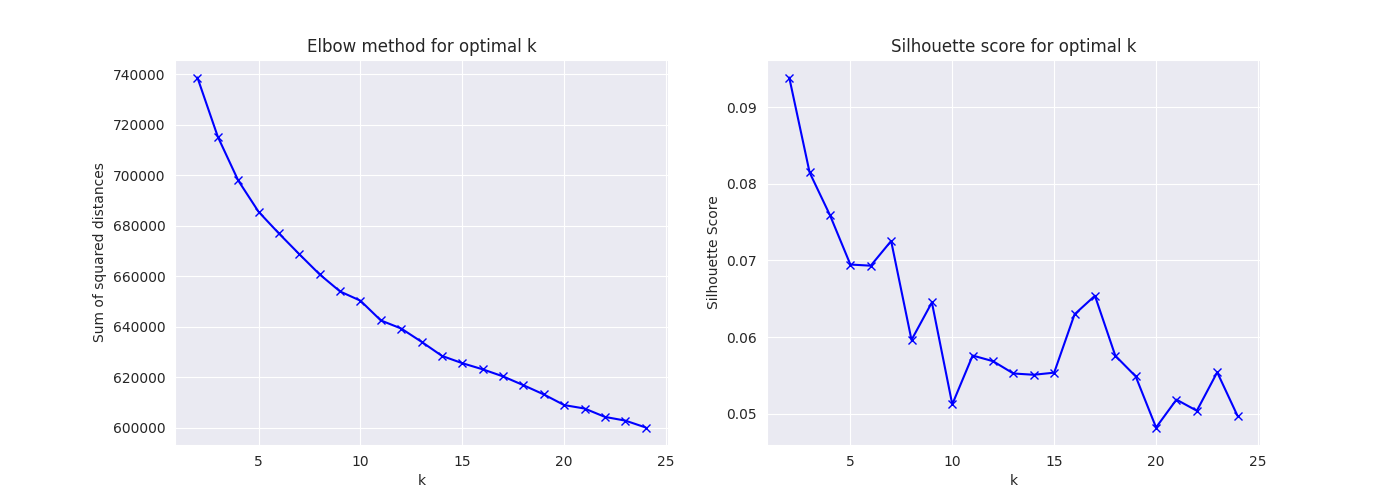

Text(0, 0.5, 'Silhouette Score')

In [52]:
fig = plt.figure(figsize=(14,5))
ax1 = fig.add_subplot(121)
ax1.set_title('Elbow method for optimal k')
ax1.plot(K, sum_of_squared_distances, 'bx-')
ax1.set_xlabel('k')
ax1.set_ylabel('Sum of squared distances')

ax2 = fig.add_subplot(122)
ax2.set_title('Silhouette score for optimal k')
ax2.plot(K, silhouette_scores, 'bx-')
ax2.set_xlabel('k')
ax2.set_ylabel('Silhouette Score')

# Only consider a set of chosen methods

In [43]:
# Randomly select k frequently occuring labels to consider for analysis
# k = 5
# Only consider labels that are "frequently" occuring
# df_subset = df[(df['count'] >= 100) & (df['count'] <= 3000)]
# np.random.seed(20) #31
# cats = np.random.choice(df_subset.label.unique(), size=k, replace=False)
# df_subset = df_subset[df_subset.label.isin(cats)]

# manually choose
cats = ['predict', 'evaluate', 'save', 'update', 'process','preprocess', 'apply', 'transform']
k = len(cats)
df_subset = df[df.label.isin(cats)]

# Assign numerical values for each category
df_subset.label = pd.Categorical(df_subset.label)
df_subset['category'] = df_subset.label.cat.codes
unique_labels = dict( enumerate(df_subset['label'].cat.categories ) )
print(f"Unique labels:{unique_labels}\nNumber of samples {len(df_subset)}")

# Use to limit the number of samples (if necessary for computational reasons)
# rndperm = np.random.permutation(df.shape[0])
# N = 10000
# df_subset = df_subset.loc[rndperm[:N],:].copy()

data_subset = df_subset.iloc[:, 0:embedding_shape-1].values

Unique labels:{0: 'apply', 1: 'evaluate', 2: 'predict', 3: 'preprocess', 4: 'process', 5: 'save', 6: 'transform', 7: 'update'}
Number of samples 1608


/home/marcus/anaconda3/envs/scc/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/home/marcus/anaconda3/envs/scc/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


## Check for similarities and analogies

In [44]:
df_subset.sort_values('category').groupby('label').first()

,0,1,2,3,4,5,6,7,8,9,...,120,121,122,123,124,125,126,127,count,category
label,,,,,,,,,,,,,,,,,,,,,
apply,-0.350060,-0.635622,0.952413,0.460420,-0.928835,0.338858,0.923269,0.937203,-0.971587,-0.901431,...,-0.351807,0.129752,0.040495,0.851744,0.957719,-0.997147,0.550607,-0.495251,66,0
evaluate,-0.976792,-0.808480,0.817189,-0.897624,0.850181,0.999634,-0.627684,0.822595,0.752881,0.955193,...,-0.755570,0.989718,-0.992987,0.873244,-0.994321,-0.974523,0.833426,0.991294,121,1
predict,-0.951812,-0.944715,-0.703542,-0.976955,-0.986304,-0.938365,0.987940,-0.572161,-0.911131,-0.998200,...,0.995098,0.773136,0.978279,-0.992782,0.996611,-0.999670,0.982983,-0.984857,580,2
preprocess,-0.953685,-0.130049,-0.371930,0.567152,-0.975093,0.975300,-0.966224,-0.971377,0.661135,0.085342,...,0.969645,-0.917997,-0.961441,0.994000,0.143467,0.082573,-0.410697,-0.400209,34,3
process,-0.786161,0.931316,0.782720,-0.030092,0.967572,-0.913836,-0.897750,0.742247,-0.710203,-0.773116,...,0.805264,-0.061379,0.797974,-0.729117,-0.576208,-0.055661,0.748256,0.990694,54,4
save,0.318869,-0.899017,0.990794,-0.924467,0.799098,0.597406,-0.928101,-0.966636,0.668779,-0.978674,...,0.984326,-0.999776,-0.992321,0.998656,-0.964319,0.873938,-0.893726,0.990241,209,5
transform,0.552829,0.379763,0.691571,0.845720,0.980747,-0.826914,0.548783,-0.643658,-0.847161,0.432989,...,-0.526897,-0.791066,0.606297,0.778809,-0.867557,-0.933330,0.644075,0.724787,384,6
update,-0.918034,0.867619,-0.586657,0.147107,-0.958537,0.956690,-0.933565,-0.976457,0.666452,-0.984894,...,0.942476,-0.930330,-0.929303,0.992765,0.101642,-0.979120,0.259986,0.260895,160,7


In [45]:
# Find similarities and analogies among the embedded targets (labels)
print(t2v.similarity('predict', 'evaluate'))
print(t2v.most_similar('apply'))

0.42148006
[('transform', 0.36150622367858887), ('accuracy', 0.3205409646034241), ('transform|image', 0.3156043589115143), ('fit', 0.31384795904159546), ('draw', 0.2892338037490845), ('merge', 0.2873463034629822), ('update|state', 0.2821924686431885), ('call', 0.27997347712516785), ('copy', 0.2782450318336487), ('|fit|transform', 0.2725980877876282)]


In [46]:
# Try to identify any similarities in code vectors
word1 = 'predict'
word2 = 'evaluate'
# Calculate cosine similarity between code vectors that represent different methods
cosine_similarities = metrics.pairwise.cosine_similarity(df_subset[df_subset['label'] == word1].iloc[:, 0:embedding_shape-1], df_subset[df_subset['label'] == word2].iloc[:, 0:embedding_shape-1])
print(df_subset[df_subset['label'] == 2].iloc[:, 0:embedding_shape-1].shape)
print(df_subset[df_subset['label'] == 4].iloc[:, 0:embedding_shape-1].shape)
print(cosine_similarities.shape)
pd.DataFrame(cosine_similarities).describe()

(0, 127)
(0, 127)
(580, 121)


,0,1,2,3,4,5,6,7,8,9,...,111,112,113,114,115,116,117,118,119,120
count,580.000000,580.000000,580.000000,580.000000,580.000000,580.000000,580.000000,580.000000,580.000000,580.000000,...,580.000000,580.000000,580.000000,580.000000,580.000000,580.000000,580.000000,580.000000,580.000000,580.000000
mean,0.066868,0.013296,0.010999,-0.012112,-0.059719,0.027486,0.092259,-0.054162,0.057091,0.068459,...,0.074308,0.045696,0.055533,0.014712,-0.017075,-0.016028,-0.000538,-0.019683,0.029820,-0.039902
std,0.189748,0.127351,0.127660,0.117262,0.163923,0.144495,0.193326,0.168403,0.199853,0.147257,...,0.187237,0.150112,0.158199,0.122908,0.172426,0.143607,0.133329,0.135543,0.163913,0.172753
min,-0.406154,-0.354502,-0.337593,-0.328013,-0.520105,-0.377039,-0.421946,-0.447634,-0.475672,-0.309001,...,-0.358451,-0.414438,-0.347793,-0.399511,-0.468917,-0.411263,-0.414752,-0.387658,-0.371231,-0.474730
25%,-0.054074,-0.067910,-0.073262,-0.093194,-0.180219,-0.067348,-0.040663,-0.177939,-0.083538,-0.027523,...,-0.054770,-0.042294,-0.067316,-0.072582,-0.131636,-0.103525,-0.095352,-0.111983,-0.082568,-0.163473
50%,0.046013,0.020875,0.017057,-0.009073,-0.060481,0.030314,0.080338,-0.066508,0.051451,0.069656,...,0.061095,0.043190,0.038989,0.015146,-0.003476,-0.022187,-0.008562,-0.020580,0.019736,-0.030850
75%,0.175344,0.092046,0.106797,0.064859,0.058894,0.121981,0.200918,0.074560,0.213997,0.168335,...,0.164620,0.126085,0.169326,0.101543,0.112212,0.083520,0.091933,0.074910,0.125465,0.089549
max,0.748682,0.421986,0.382511,0.435304,0.366444,0.498137,0.754010,0.988766,1.000000,0.476164,...,0.732101,0.651001,0.500812,0.349393,0.398923,0.440760,0.445041,0.325898,0.483014,0.507714


## PCA

Cumulative explained variation for 100 principal components: 0.9804970884209421


<IPython.core.display.Javascript object>


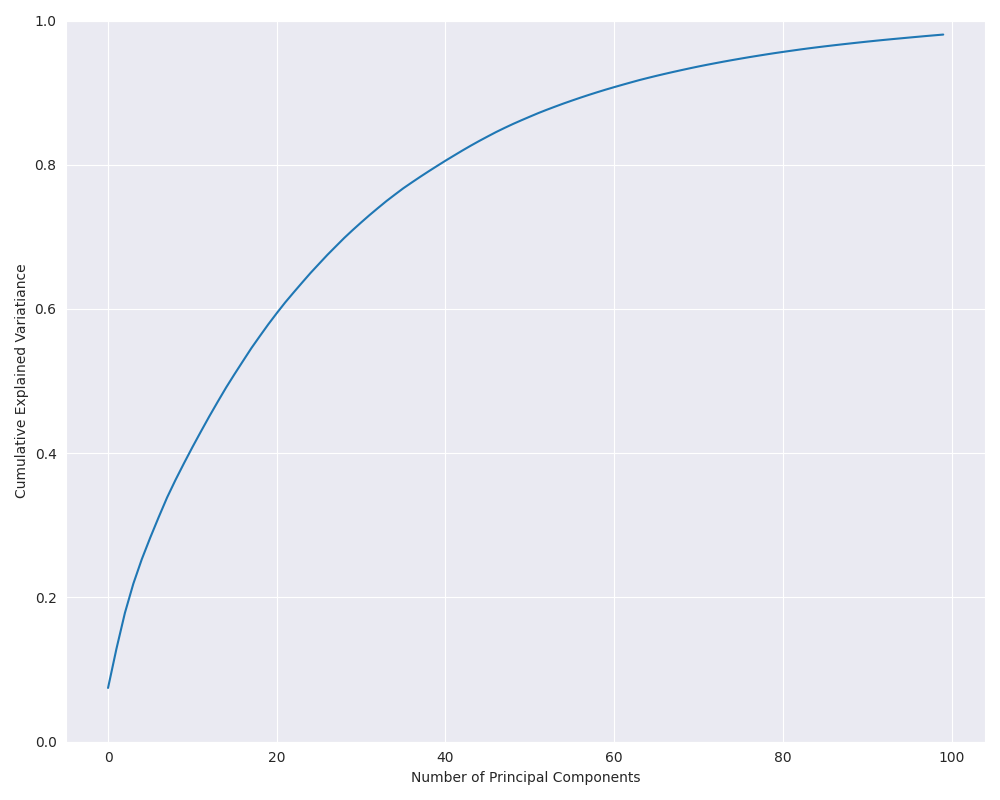

In [47]:
pca = PCA(n_components=100)
pca_result = pca.fit_transform(data_subset)

print(f"Cumulative explained variation for {len(pca.explained_variance_ratio_)} principal components: {np.sum(pca.explained_variance_ratio_)}")
plt.figure(figsize=(10,8))
plt.plot(np.arange(len(pca.explained_variance_ratio_)), np.cumsum(pca.explained_variance_ratio_))
plt.ylim([0, 1])
plt.ylabel('Cumulative Explained Variatiance')
plt.xlabel('Number of Principal Components')
plt.tight_layout()

## t-SNE

In [48]:
# t-SNE
tsne2d = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=3000)
tsne_result_2d = tsne2d.fit_transform(data_subset)

tsne3d = TSNE(n_components=3, verbose=1, perplexity=30, n_iter=3000)
tsne_result_3d = tsne3d.fit_transform(data_subset)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1608 samples in 0.008s...
[t-SNE] Computed neighbors for 1608 samples in 0.378s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1608
[t-SNE] Computed conditional probabilities for sample 1608 / 1608
[t-SNE] Mean sigma: 2.753064
[t-SNE] KL divergence after 250 iterations with early exaggeration: 89.803528
[t-SNE] KL divergence after 3000 iterations: 1.869371
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1608 samples in 0.011s...
[t-SNE] Computed neighbors for 1608 samples in 0.412s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1608
[t-SNE] Computed conditional probabilities for sample 1608 / 1608
[t-SNE] Mean sigma: 2.753064
[t-SNE] KL divergence after 250 iterations with early exaggeration: 103.974251
[t-SNE] KL divergence after 3000 iterations: 1.845402


# K-means Clustering and Visualization with t-SNE & PCA
Here we have selected a subset of methods, using their name as the label and try to cluster by their code vector representations.

Number of clusters: 8
Homogeneity: 0.007
Completeness: 0.006
V-measure: 0.007
Adjusted Rand Index: 0.001
Adjusted Mutual Information: -0.002
Silhouette Coefficient: 0.062


<IPython.core.display.Javascript object>


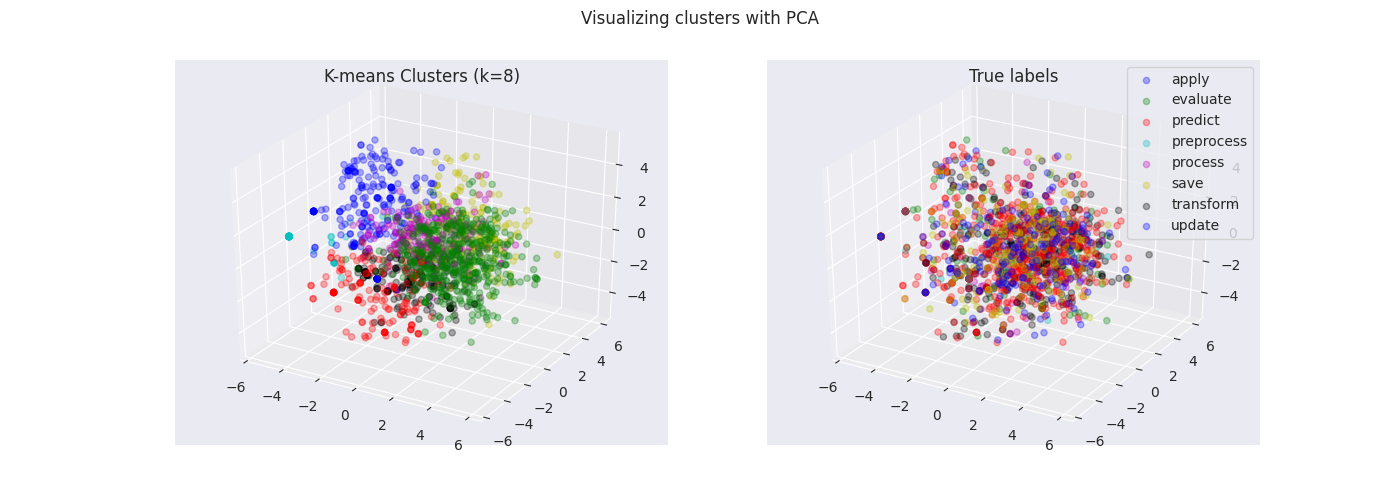

<IPython.core.display.Javascript object>


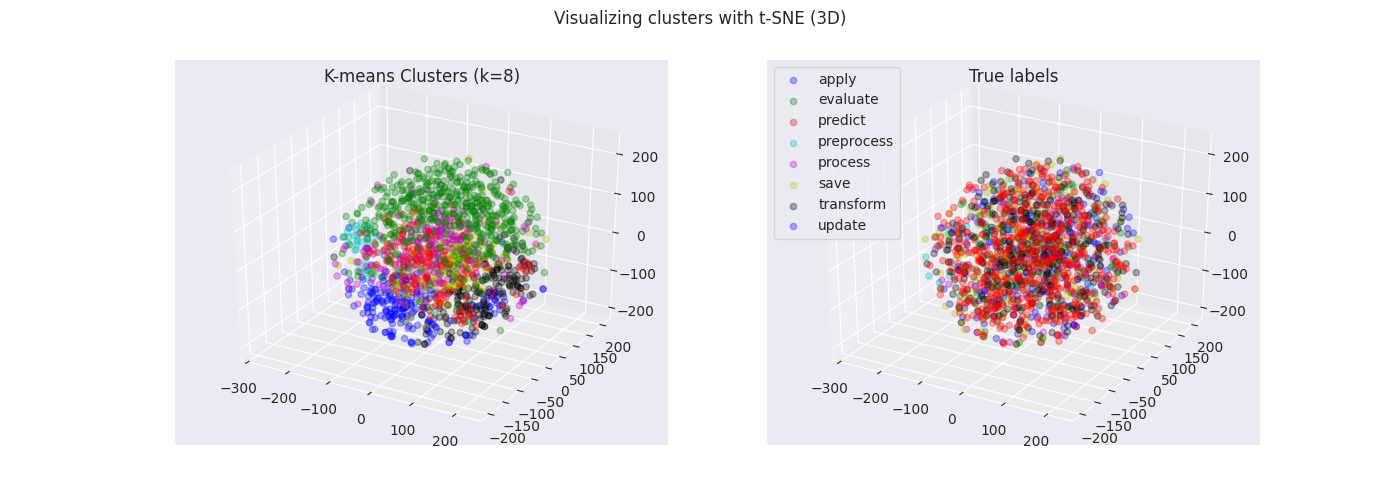

<IPython.core.display.Javascript object>


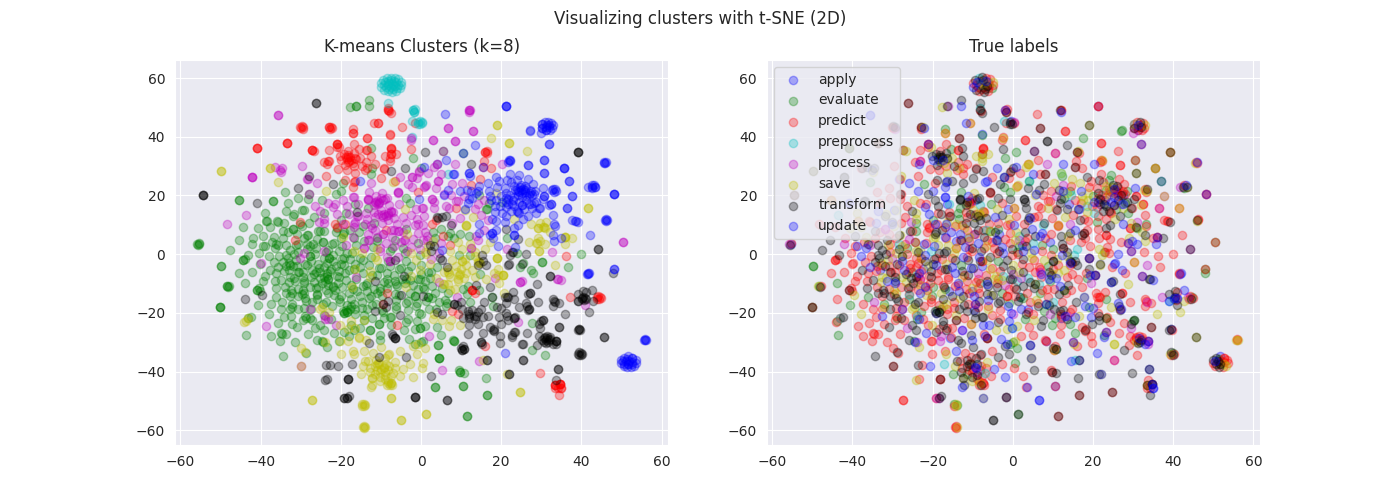

In [49]:
# Apply K-means
kmeans = KMeans(n_clusters=k, random_state=0).fit(data_subset)

print('Number of clusters: %d' % k)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(df_subset['category'], kmeans.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(df_subset['category'], kmeans.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(df_subset['category'], kmeans.labels_))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(df_subset['category'], kmeans.labels_))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(df_subset['category'], kmeans.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(data_subset, kmeans.labels_, metric='sqeuclidean'))


# Try to visualize clusters using PCA
fig = plt.figure(figsize=(14,5))
fig.suptitle('Visualizing clusters with PCA')
ax1 = fig.add_subplot(121, projection='3d')
ax1.set_title(f'K-means Clusters (k={k})')
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for klass, color in zip(range(0, k), colors):
    Xk = pca_result[kmeans.labels_ == klass]
    ax1.scatter(Xk[:, 0], Xk[:, 1], Xk[:, 2], c=color, alpha=0.3)

ax2 = fig.add_subplot(122, projection='3d')
ax2.set_title('True labels')
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for klass, color in zip(range(0, k), colors):
    Xk = pca_result[df_subset['category'] == klass]
    ax2.scatter(Xk[:, 0], Xk[:, 1], Xk[:, 2], c=color, alpha=0.3, label=unique_labels[klass])

ax2.legend()

# Try to visualize clusters using t-SNE in 3D
fig = plt.figure(figsize=(14,5))
fig.suptitle('Visualizing clusters with t-SNE (3D)')
ax1 = fig.add_subplot(121, projection='3d')
ax1.set_title(f'K-means Clusters (k={k})')
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for klass, color in zip(range(0, k), colors):
    Xk = tsne_result_3d[kmeans.labels_ == klass]
    ax1.scatter(Xk[:, 0], Xk[:, 1], Xk[:, 2], c=color, alpha=0.3, label=unique_labels[klass])


ax2 = fig.add_subplot(122, projection='3d')
ax2.set_title('True labels')
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for klass, color in zip(range(0, k), colors):
    Xk = tsne_result_3d[df_subset['category'] == klass]
    ax2.scatter(Xk[:, 0], Xk[:, 1], Xk[:, 2], c=color, alpha=0.3, label=unique_labels[klass])

ax2.legend()

# Try to visualize clusters using t-SNE in 2D
fig = plt.figure(figsize=(14,5))
fig.suptitle('Visualizing clusters with t-SNE (2D)')
ax1 = fig.add_subplot(121)
ax1.set_title(f'K-means Clusters (k={k})')
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for klass, color in zip(range(0, k), colors):
    Xk = tsne_result_2d[kmeans.labels_ == klass]
    ax1.scatter(Xk[:, 0], Xk[:, 1], c=color, alpha=0.3, label=unique_labels[klass])


ax2 = fig.add_subplot(122)
ax2.set_title('True labels')
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for klass, color in zip(range(0, k), colors):
    Xk = tsne_result_2d[df_subset['category'] == klass]
    ax2.scatter(Xk[:, 0], Xk[:, 1], c=color, alpha=0.3, label=unique_labels[klass])
    
ax2.legend()

/home/marcus/anaconda3/envs/scc/lib/python3.7/site-packages/sklearn/cluster/_optics.py:802: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


---------- METRICS FOR OPTICS ----------
Number of clusters: 22
Homogeneity: 0.015
Completeness: 0.032
V-measure: 0.021
Adjusted Rand Index: -0.007
Adjusted Mutual Information: -0.005
Silhouette Coefficient: -0.092
---------- METRICS FOR DBSCAN EPS 0.1 ----------
Number of clusters: 6
Homogeneity: 0.006
Completeness: 0.030
V-measure: 0.010
Adjusted Rand Index: -0.007
Adjusted Mutual Information: -0.003
Silhouette Coefficient: -0.104
---------- METRICS FOR DBSCAN EPS 0.5 ----------
Number of clusters: 6
Homogeneity: 0.006
Completeness: 0.013
V-measure: 0.008
Adjusted Rand Index: -0.002
Adjusted Mutual Information: -0.002
Silhouette Coefficient: -0.141


<IPython.core.display.Javascript object>


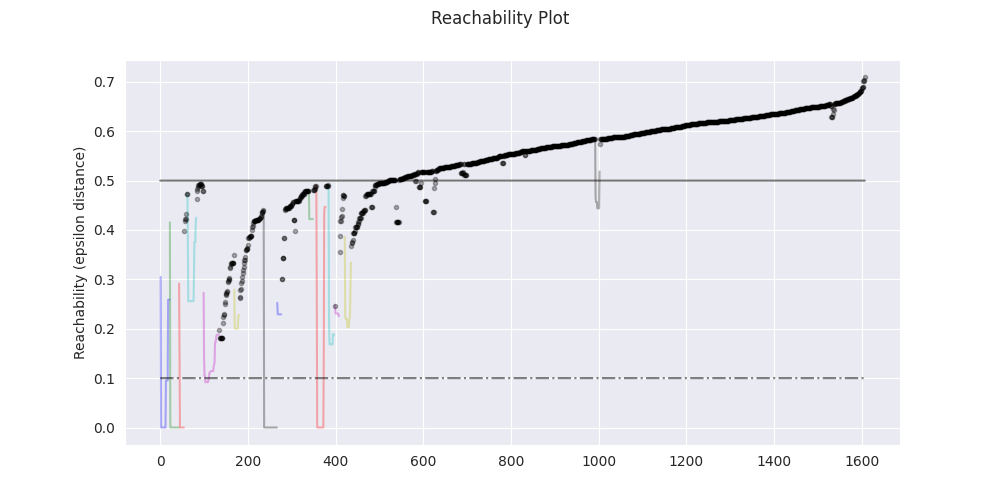

<IPython.core.display.Javascript object>


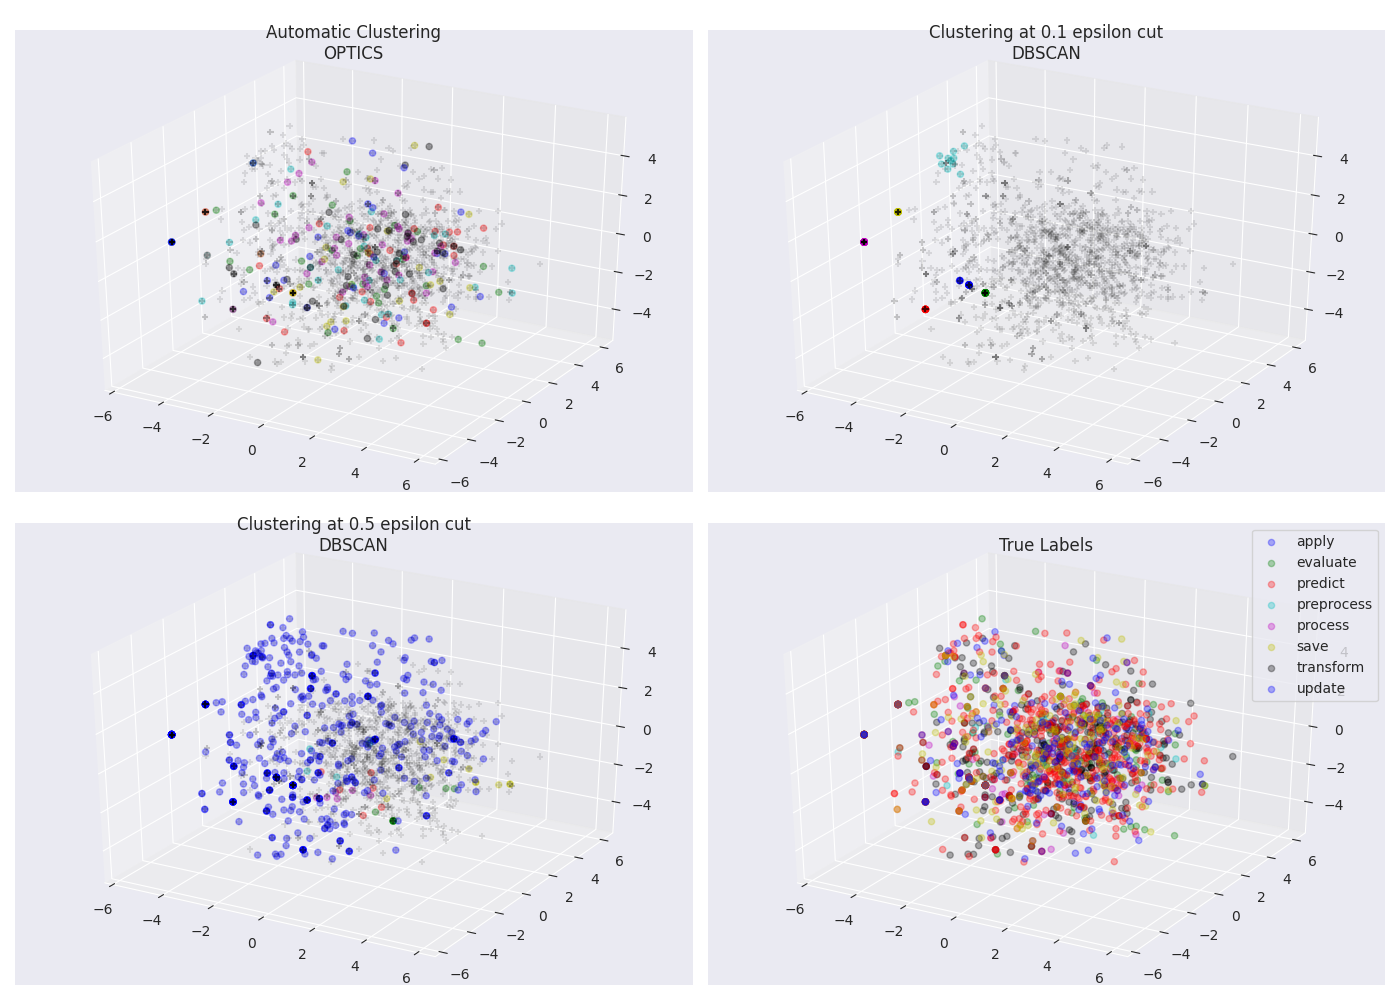

In [50]:
# Apply OPTICS algorithm
eps = [0.1, 0.5]
model = OPTICS(cluster_method='xi', min_samples=10, metric='cosine')
model.fit(data_subset)

labels_eps0 = cluster_optics_dbscan(reachability=model.reachability_,
                                   core_distances=model.core_distances_,
                                   ordering=model.ordering_, eps=eps[0])
labels_eps1 = cluster_optics_dbscan(reachability=model.reachability_,
                                   core_distances=model.core_distances_,
                                   ordering=model.ordering_, eps=eps[1])

space = np.arange(len(data_subset))
reachability = model.reachability_[model.ordering_]
optics_labels = model.labels_[model.ordering_]


print(f'{"-"*10} METRICS FOR OPTICS {"-"*10}')
print('Number of clusters: %d' % len(model.cluster_hierarchy_))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(df_subset['category'], optics_labels))
print("Completeness: %0.3f" % metrics.completeness_score(df_subset['category'], optics_labels))
print("V-measure: %0.3f" % metrics.v_measure_score(df_subset['category'], optics_labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(df_subset['category'], optics_labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(df_subset['category'], optics_labels))
if (len(model.cluster_hierarchy_) > 1):
    print("Silhouette Coefficient: %0.3f"
          % metrics.silhouette_score(data_subset, optics_labels, metric='sqeuclidean'))

print(f'{"-"*10} METRICS FOR DBSCAN EPS {eps[0]} {"-"*10}')
print('Number of clusters: %d' % len(np.unique(labels_eps0[labels_eps0 > -1])))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(df_subset['category'], labels_eps0))
print("Completeness: %0.3f" % metrics.completeness_score(df_subset['category'], labels_eps0))
print("V-measure: %0.3f" % metrics.v_measure_score(df_subset['category'], labels_eps0))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(df_subset['category'], labels_eps0))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(df_subset['category'], labels_eps0))
if (len(np.unique(labels_eps0[labels_eps0 > -1])) > 1):
    print("Silhouette Coefficient: %0.3f"
          % metrics.silhouette_score(data_subset, labels_eps0, metric='sqeuclidean'))

print(f'{"-"*10} METRICS FOR DBSCAN EPS {eps[1]} {"-"*10}')
print('Number of clusters: %d' % len(np.unique(labels_eps1[labels_eps1 > -1])))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(df_subset['category'], labels_eps1))
print("Completeness: %0.3f" % metrics.completeness_score(df_subset['category'], labels_eps1))
print("V-measure: %0.3f" % metrics.v_measure_score(df_subset['category'], labels_eps1))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(df_subset['category'], labels_eps1))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(df_subset['category'], labels_eps1))
if (len(np.unique(labels_eps1[labels_eps1 > -1])) > 1):
    print("Silhouette Coefficient: %0.3f"
          % metrics.silhouette_score(data_subset, labels_eps1, metric='sqeuclidean'))


labels = ['N/A']
for val in unique_labels.values():
    labels.append(val)

# Reachability plot
plt.figure(figsize=(10, 5))
plt.suptitle('Reachability Plot')
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for klass, color in zip(range(0, len(model.cluster_hierarchy_)), colors):
    Xk = space[optics_labels == klass]
    Rk = reachability[optics_labels == klass]
    plt.plot(Xk, Rk, color, alpha=0.3)
plt.plot(space[optics_labels == -1], reachability[optics_labels == -1], 'k.', alpha=0.3)
plt.plot(space, np.full_like(space, eps[0], dtype=float), 'k-.', alpha=0.5)
plt.plot(space, np.full_like(space, eps[1], dtype=float), 'k-', alpha=0.5)
plt.ylabel('Reachability (epsilon distance)')



# Scatter plots
fig = plt.figure(figsize=(14, 10))
ax1 = fig.add_subplot(221, projection='3d')
ax1.set_title('Automatic Clustering\nOPTICS')
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
ax1.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c='k', marker='+', alpha=0.1)
for klass, color in zip(range(0, len(model.cluster_hierarchy_)), colors):
    Xk = pca_result[optics_labels == klass]
    ax1.scatter(Xk[:, 0], Xk[:, 1], Xk[:, 2], c=color, alpha=0.3)
    
ax2 = fig.add_subplot(222, projection='3d')
ax2.set_title(f'Clustering at {eps[0]} epsilon cut\nDBSCAN')
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
ax2.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c='k', marker='+', alpha=0.1)
for klass, color in zip(range(0, len(np.unique(labels_eps0))), colors):
    Xk = pca_result[labels_eps0 == klass]
    ax2.scatter(Xk[:, 0], Xk[:, 1], Xk[:, 2], c=color, alpha=0.3)
    

ax3 = fig.add_subplot(223, projection='3d')
ax3.set_title(f'Clustering at {eps[1]} epsilon cut\nDBSCAN')
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
ax3.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c='k', marker='+', alpha=0.1)
for klass, color in zip(range(0, len(np.unique(labels_eps1))), colors):
    Xk = pca_result[labels_eps1 == klass]
    ax3.scatter(Xk[:, 0], Xk[:, 1], Xk[:, 2], c=color, alpha=0.3)


ax4 = fig.add_subplot(224, projection='3d')
ax4.set_title('True Labels')
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for klass, color in zip(range(0, k), colors):
    Xk = pca_result[df_subset['category'] == klass]
    ax4.scatter(Xk[:, 0], Xk[:, 1], Xk[:, 2], c=color, alpha=0.3, label=unique_labels[klass])
ax4.legend()
plt.tight_layout()

## OPTICS with t-SNE (2D)

<IPython.core.display.Javascript object>


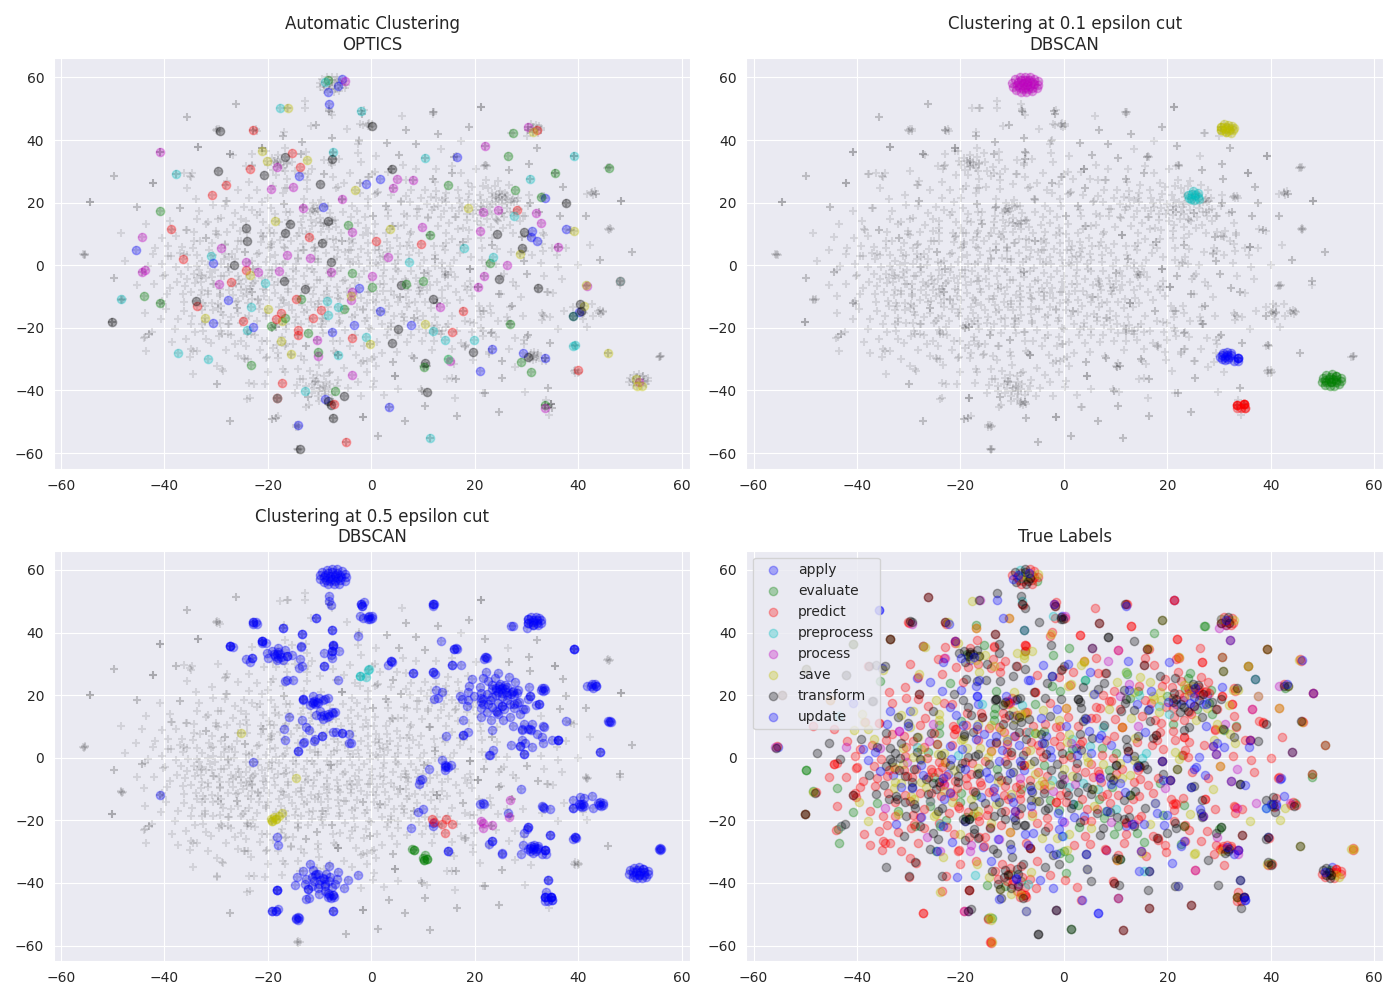

In [51]:
# Scatter plots
fig = plt.figure(figsize=(14, 10))
ax1 = fig.add_subplot(221)
ax1.set_title('Automatic Clustering\nOPTICS')
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
ax1.scatter(tsne_result_2d[:, 0], tsne_result_2d[:, 1], c='k', marker='+', alpha=0.1)
for klass, color in zip(range(0, len(model.cluster_hierarchy_)), colors):
    Xk = tsne_result_2d[optics_labels == klass]
    ax1.scatter(Xk[:, 0], Xk[:, 1], c=color, alpha=0.3)
    
ax2 = fig.add_subplot(222)
ax2.set_title(f'Clustering at {eps[0]} epsilon cut\nDBSCAN')
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
ax2.scatter(tsne_result_2d[:, 0], tsne_result_2d[:, 1], c='k', marker='+', alpha=0.1)
for klass, color in zip(range(0, k), colors):
    Xk = tsne_result_2d[labels_eps0 == klass]
    ax2.scatter(Xk[:, 0], Xk[:, 1], c=color, alpha=0.3)
    

ax3 = fig.add_subplot(223)
ax3.set_title(f'Clustering at {eps[1]} epsilon cut\nDBSCAN')
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
ax3.scatter(tsne_result_2d[:, 0], tsne_result_2d[:, 1], c='k', marker='+', alpha=0.1)
for klass, color in zip(range(0, k), colors):
    Xk = tsne_result_2d[labels_eps1 == klass]
    ax3.scatter(Xk[:, 0], Xk[:, 1], c=color, alpha=0.3)


ax4 = fig.add_subplot(224)
ax4.set_title('True Labels')
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for klass, color in zip(range(0, k), colors):
    Xk = tsne_result_2d[df_subset['category'] == klass]
    ax4.scatter(Xk[:, 0], Xk[:, 1], c=color, alpha=0.3, label=unique_labels[klass])
ax4.legend()
plt.tight_layout()